<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install tensorflow
!pip install tensorflow-gpu

     |████████████████████████████████| 516.2MB 29kB/s 


In [2]:
pip install --upgrade tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [0]:
import tensorflow
import tensorflow.keras as keras

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation, Dropout
from keras.layers import BatchNormalization
from keras.metrics import BinaryAccuracy
from keras import optimizers

from keras.metrics import Recall

import pandas
import matplotlib.pyplot as plt
from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'

In [3]:
drive.mount(ROOT)
HOME = join(ROOT,'My Drive')
COLAB_DIR = join(HOME, 'Colab Notebooks')
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = data.drop(['Unnamed: 0', 'VAL', 'NUM_OF_TRANSACTIONS','CLOSE_ONE_DAY_BEFORE'], axis=1).rename(columns={'DTYYYYMMDD': 'DATE'})
data['DATE'] = pandas.to_datetime(data['DATE'],format='%Y%m%d')

In [5]:
labels = pandas.DataFrame()
labels['CLASS'] = numpy.where(data['CLOSE'] > data['CLOSE'].shift(1), 1.0, 0.0)
labels['DATE'] = data['DATE'].copy()
labels['TICKER'] = data['TICKER'].copy()
labels.head(10)

,CLASS,DATE,TICKER
0,0.0,2019-11-20,مظنه
1,0.0,2019-11-23,مظنه
2,0.0,2019-11-24,مظنه
3,0.0,2019-11-25,مظنه
4,0.0,2019-11-26,مظنه
5,0.0,2019-11-27,مظنه
6,0.0,2019-11-30,مظنه
7,0.0,2019-12-01,مظنه
8,0.0,2019-12-02,مظنه
9,0.0,2019-12-03,مظنه


Let's assert if we are using GPU.

In [6]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## **Visualization Task**

**Let's do some visualizations first to investigate data set we are working with**

In [7]:
mean_vol_per_ticker = data.groupby('TICKER')['VOL'].agg(numpy.mean).reset_index().sort_values('VOL', ascending=False)
mean_vol_per_ticker.head()

,TICKER,VOL
894,شاخص_قيمت(هم_وزن6),1.560700e+09
895,شاخص_قيمت6,1.559693e+09
898,شاخص_كل_(هم_وزن)6,1.559693e+09
889,شاخص_آزاد_شناور6,9.130124e+08
897,شاخص_كل6,8.711138e+08


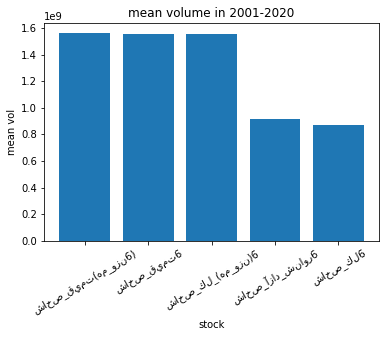

In [8]:
 five_first_stocks_with_mean_vol = mean_vol_per_ticker.head()
 index = numpy.arange(len(five_first_stocks_with_mean_vol['TICKER']))
 plt.bar(index, five_first_stocks_with_mean_vol['VOL'])
 plt.xlabel('stock', fontsize=10)
 plt.ylabel('mean vol', fontsize=10)
 plt.xticks(index, five_first_stocks_with_mean_vol['TICKER'], fontsize=10, rotation=30)
 plt.title('mean volume in 2001-2020')
 plt.show()

In [9]:
data_for_ticker_with_max_mean_vol = data[ data['TICKER'] == mean_vol_per_ticker.head().iloc[0]['TICKER'] ]
data_for_ticker_with_max_mean_vol.head()

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOL
3004878,شاخص_قيمت(هم_وزن6),2015-02-24,9198.4,9181.8,9181.8,9181.8,278521094
3004879,شاخص_قيمت(هم_وزن6),2015-02-25,9183.3,9109.1,9109.2,9109.1,271188153
3004880,شاخص_قيمت(هم_وزن6),2015-02-28,9111.9,9090.0,9090.0,9090.0,257849083
3004881,شاخص_قيمت(هم_وزن6),2015-03-01,9014.4,9030.4,9009.0,9030.4,475683577
3004882,شاخص_قيمت(هم_وزن6),2015-03-02,9034.4,9043.5,9034.4,9043.5,717632564


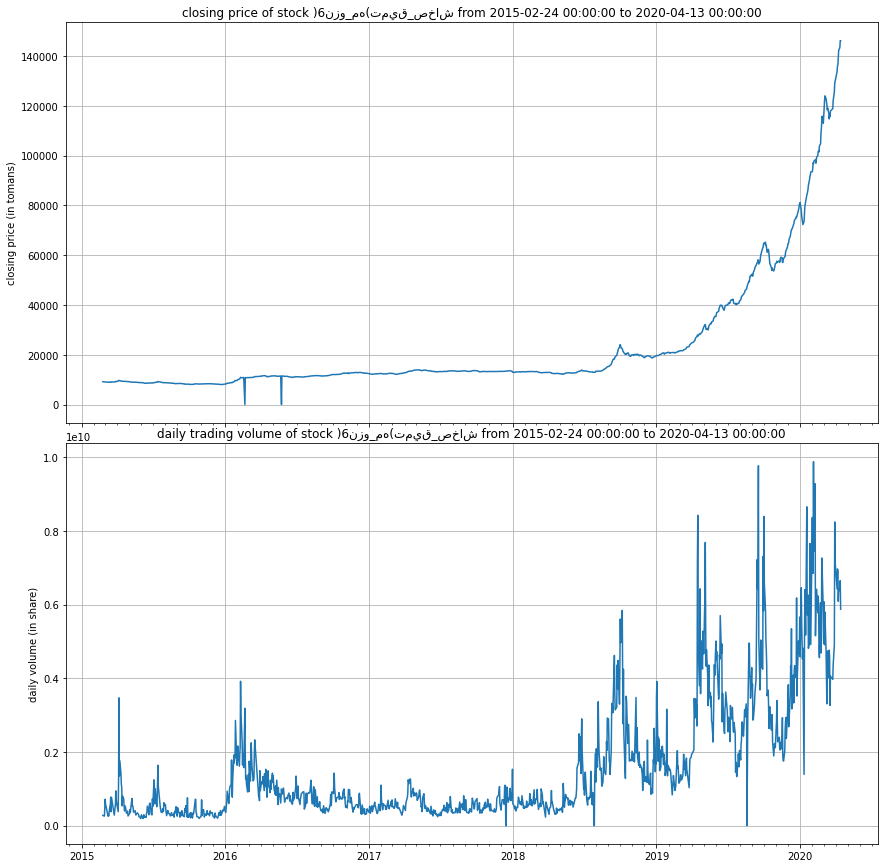

In [10]:
import matplotlib.dates as mdates

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,12))
fig.tight_layout()

ax1 = axs[0]
ax2 = axs[1]
starting_date = str(data_for_ticker_with_max_mean_vol['DATE'].iloc[0])
ending_date = str(data_for_ticker_with_max_mean_vol['DATE'].iloc[len(data_for_ticker_with_max_mean_vol) - 1])

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)


ax1.plot(data_for_ticker_with_max_mean_vol['DATE'], data_for_ticker_with_max_mean_vol['CLOSE'])
ax1.set(ylabel='closing price (in tomans)')
ax1.set_title('closing price of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date + ' to ' + ending_date)
ax2.plot(data_for_ticker_with_max_mean_vol['DATE'], data_for_ticker_with_max_mean_vol['VOL'])
ax2.set(ylabel='daily volume (in share)')
ax2.set_title('daily trading volume of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date + ' to ' + ending_date)

ax1.grid(True)
ax2.grid(True)

ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax1.format_ydata = lambda x: '$%1.2f' % x  # format the price.

plt.show()

In [11]:
ten_stocks_with_max_trading_days = data.groupby('TICKER').agg({'DATE': ['min', 'max', 'count'], 'VOL': ['mean']}).reset_index().sort_values(('DATE', 'count'), ascending=False).head(10)
stock_with_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[0]
ten_stocks_with_max_trading_days.head(10)

TICKER       DATE                            VOL
                   min        max count          mean
1616  وپترو 2001-03-25 2020-04-13  4366  2.323352e+06
1522  وساخت 2001-03-25 2020-04-13  4356  1.464725e+06
56    آريان 2010-10-06 2020-04-13  4347  2.723661e+06
624   خودرو 2001-03-25 2020-04-13  4340  1.123416e+07
1539   وسپه 2001-03-27 2020-04-13  4323  2.620691e+06
753   زنجان 2011-01-05 2020-04-13  4318  9.637195e+05
567   خبهمن 2001-04-07 2020-04-13  4315  6.061205e+06
1603  ونيكي 2001-04-07 2020-04-13  4302  1.712802e+06
900   شاراك 2001-03-27 2020-04-13  4298  2.342162e+06
1474  وبشهر 2001-03-25 2020-04-13  4291  2.265908e+06

## **Training Phase on the stock with max trading days**

**Now it is time to start training our model**

We use adam optimizer throughout this experiment.

In [0]:
optimizer = optimizers.Adam(learning_rate=0.001)

In [0]:
from numpy.random import uniform

window_in_days = 10

class MyNormalizer:
  def __init__(self):
    self.max = 0
    self.min = 0

  def fit(self, data):
    self.max = data.max()
    self.min = data.min()
  
  def transform(self, data):
    return (data - self.min) / (self.max - self.min)


def align_data(x, y, window_in_days, batch_size):
  rows_to_insert_to_x = pandas.DataFrame(numpy.zeros((window_in_days+(batch_size - len(x) % batch_size),len(x.columns))), columns=x.columns)
  rows_to_insert_to_y = pandas.DataFrame(numpy.zeros((window_in_days+(batch_size - len(x) % batch_size), len(y.columns))), columns=y.columns)

  return pandas.concat([rows_to_insert_to_x, x], ignore_index=True), pandas.concat([rows_to_insert_to_y, y], ignore_index=True)
  

def split_data_to_train_test(original_dataset, labels, stock, training_start, training_end, testing_start, testing_end, validation_split, test_required=True):
  data_related_to_stock = original_dataset[ original_dataset['TICKER'] == stock ].drop('TICKER', axis=1)
  labels_related_to_stock = labels[ labels['TICKER'] == stock ].drop('TICKER', axis=1)

 
  training_period_mask = (data_related_to_stock['DATE'] >= training_start) & (data_related_to_stock['DATE'] <= training_end ) 
  training_period = data_related_to_stock.loc[training_period_mask].drop('DATE', axis=1)
  training_period_labels = labels_related_to_stock.loc[training_period_mask].drop('DATE', axis=1)

  train_split, data_validation_split = numpy.split(training_period, [int( (1 - validation_split) * len(training_period))])
  train_labels_split, validation_labels_split = numpy.split(training_period_labels, [int( (1 - validation_split) * len(training_period_labels))])

  testing_period = None
  testing_period_labels = None
  if test_required:
    testing_period_mask = (data_related_to_stock['DATE'] >= testing_start) & (data_related_to_stock['DATE'] <= testing_end )
    testing_period = data_related_to_stock.loc[testing_period_mask].drop('DATE', axis=1)
    testing_period_labels = labels_related_to_stock.loc[testing_period_mask].drop('DATE', axis=1)

  return train_split, train_labels_split, data_validation_split, validation_labels_split , testing_period, testing_period_labels


def normalize_dataframe_with_max_min(dataframe, train_max, train_min):
    normalized_df=(dataframe - train_min)/(train_max - train_min)
    return normalized_df


def generate_datasets_for_model(original_dataset, labels, stock, training_start, training_end, \
                                testing_start, testing_end, window_in_days=10, batch_size=32, validation_split=0.2, test_required=True):
  normalizer = MyNormalizer()
  training_data = []
  training_labels = []
  validation_data = []
  validation_labels = []
  testing_data = []
  testing_labels = []

  training_period, training_period_labels, validation_period, validation_period_labels, testing_period, \
        testing_period_labels = split_data_to_train_test(original_dataset, labels, stock, training_start, training_end, testing_start, testing_end, validation_split, test_required)

  training_period, training_period_labels = align_data(training_period, training_period_labels, window_in_days, batch_size)
  if validation_split != 0.0:
    validation_period, validation_period_labels = align_data(validation_period, validation_period_labels, window_in_days, batch_size)
  if test_required:
    testing_period, testing_period_labels = align_data(testing_period, testing_period_labels, window_in_days, batch_size)                                                                                               

  normalizer.fit(training_period)
  training_period = normalizer.transform(training_period)

  for j in range(window_in_days, len(training_period)):
    training_data.append(numpy.array(training_period[ j - window_in_days : j ].copy()))
    training_labels.append(numpy.array(training_period_labels.iloc[j]))

  training_data = numpy.array(training_data)
  training_labels = numpy.array(training_labels)

  if validation_split != 0.0:
    validation_period = normalizer.transform(validation_period)
    for j in range(window_in_days, len(validation_period)):
      validation_data.append(numpy.array(validation_period[ j - window_in_days : j ].copy()))
      validation_labels.append(numpy.array(validation_period_labels.iloc[j]))

  validation_data = numpy.array(validation_data)
  validation_labels = numpy.array(validation_labels)

  if test_required:
    testing_period = normalizer.transform(testing_period)
    for j in range(window_in_days, len(testing_period)):
      testing_data.append(numpy.array(testing_period[ j - window_in_days : j ].copy()))
      testing_labels.append(numpy.array(testing_period_labels.iloc[j]))

  testing_data = numpy.array(testing_data)
  testing_labels = numpy.array(testing_labels)


  return training_data, training_labels, validation_data, validation_labels, testing_data, testing_labels



In [0]:
training_start = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

In [0]:

def build_model(input_shape, optimizer='adam', layers=None, loss='binary_crossentropy', metrics=[BinaryAccuracy()]):
  if layers is None:
    model = Sequential()
    model.add(LSTM(64, input_shape=(input_shape[1], input_shape[2])))
    model.add(Dense(32))
    model.add(Dropout(0.1))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dense(4))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

  else:
    model = Sequential(layers)
  
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)


  return model


**First of all, we train the model with training set and testing set containing information in the range indicated periods in the code. we first set the window length to 10 days.**

In [0]:
training_data, training_labels, validation_data, validation_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, validation_split=0.1)

model = build_model(training_data.shape, optimizer)
model.summary()

(3392, 10, 5)

In [0]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=200,
                    shuffle=False,
                    validation_data=(validation_data, validation_labels))

Train on 3392 samples, validate on 384 samples
Epoch 1/200
3392/3392 [==============================] - 3s 1ms/step - loss: 0.6870 - binary_accuracy: 0.5873 - val_loss: 0.6540 - val_binary_accuracy: 0.6510
Epoch 2/200
3392/3392 [==============================] - 3s 828us/step - loss: 0.6705 - binary_accuracy: 0.6050 - val_loss: 0.6626 - val_binary_accuracy: 0.6510
Epoch 3/200
3392/3392 [==============================] - 3s 833us/step - loss: 0.6696 - binary_accuracy: 0.6091 - val_loss: 0.6680 - val_binary_accuracy: 0.6250
Epoch 4/200
3392/3392 [==============================] - 3s 825us/step - loss: 0.6651 - binary_accuracy: 0.6120 - val_loss: 0.6962 - val_binary_accuracy: 0.6198
Epoch 5/200
3392/3392 [==============================] - 3s 819us/step - loss: 0.6621 - binary_accuracy: 0.6188 - val_loss: 0.7776 - val_binary_accuracy: 0.4115
Epoch 6/200
3392/3392 [==============================] - 3s 822us/step - loss: 0.6597 - binary_accuracy: 0.6200 - val_loss: 0.8253 - val_binary_accura

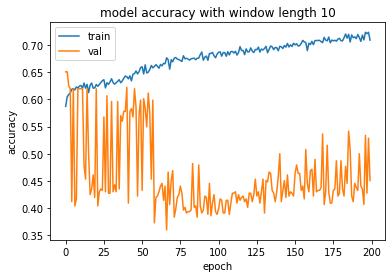

In [0]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

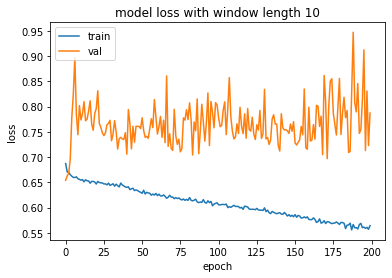

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 10 we have: test loss, test acc:', results)

160/160 [==============================] - 0s 143us/step
for window length 10 we have: test loss, test acc: [0.6843322530388832, 0.5562499761581421]


**Next, we train the model with window size 20 to see how the increase of window size affects the test accuracy**

In [0]:
training_data, training_labels, validation_data, validation_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, window_in_days=20)

model = build_model(training_data.shape, optimizer)

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                

In [0]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=200,
                    shuffle=False,
                    validation_data=(validation_data, validation_labels))

Train on 3008 samples, validate on 768 samples
Epoch 1/200
3008/3008 [==============================] - 5s 2ms/step - loss: 0.6928 - binary_accuracy: 0.5814 - val_loss: 0.6701 - val_binary_accuracy: 0.6185
Epoch 2/200
3008/3008 [==============================] - 4s 1ms/step - loss: 0.6714 - binary_accuracy: 0.6024 - val_loss: 0.7056 - val_binary_accuracy: 0.6185
Epoch 3/200
3008/3008 [==============================] - 4s 1ms/step - loss: 0.6651 - binary_accuracy: 0.6100 - val_loss: 0.7085 - val_binary_accuracy: 0.5951
Epoch 4/200
3008/3008 [==============================] - 4s 1ms/step - loss: 0.6656 - binary_accuracy: 0.6174 - val_loss: 0.7348 - val_binary_accuracy: 0.5938
Epoch 5/200
3008/3008 [==============================] - 4s 1ms/step - loss: 0.6600 - binary_accuracy: 0.6223 - val_loss: 0.8933 - val_binary_accuracy: 0.5951
Epoch 6/200
3008/3008 [==============================] - 4s 1ms/step - loss: 0.6578 - binary_accuracy: 0.6190 - val_loss: 0.9630 - val_binary_accuracy: 0.5977

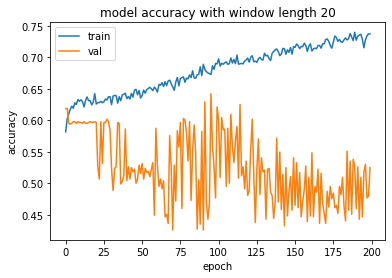

In [0]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 20')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

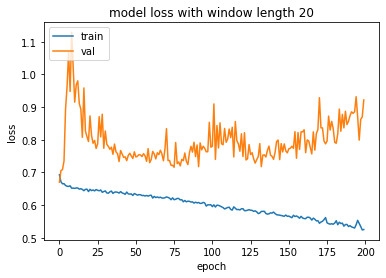

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 20 we have: test loss, test acc:', results)

160/160 [==============================] - 0s 202us/step
for window length 20 we have: test loss, test acc: [0.9741903234273195, 0.668749988079071]


**And finally, we set the window length to 30 days.**

In [0]:
training_data, training_labels, validation_data, validation_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, window_in_days=30)

model = build_model(training_data.shape, optimizer)

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_11 (Batc (None, 16)                64        
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_44 (Dense)             (None, 1)               

In [0]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=200,
                    shuffle=False,
                    validation_data=(validation_data,validation_labels))

Train on 3008 samples, validate on 768 samples
Epoch 1/200
3008/3008 [==============================] - 7s 2ms/step - loss: 0.7009 - binary_accuracy: 0.5861 - val_loss: 0.6642 - val_binary_accuracy: 0.6185
Epoch 2/200
3008/3008 [==============================] - 6s 2ms/step - loss: 0.6684 - binary_accuracy: 0.6197 - val_loss: 0.6863 - val_binary_accuracy: 0.6185
Epoch 3/200
3008/3008 [==============================] - 6s 2ms/step - loss: 0.6712 - binary_accuracy: 0.6084 - val_loss: 0.6845 - val_binary_accuracy: 0.5951
Epoch 4/200
3008/3008 [==============================] - 6s 2ms/step - loss: 0.6648 - binary_accuracy: 0.6147 - val_loss: 0.7039 - val_binary_accuracy: 0.5964
Epoch 5/200
3008/3008 [==============================] - 6s 2ms/step - loss: 0.6613 - binary_accuracy: 0.6197 - val_loss: 0.8341 - val_binary_accuracy: 0.5964
Epoch 6/200
3008/3008 [==============================] - 6s 2ms/step - loss: 0.6558 - binary_accuracy: 0.6263 - val_loss: 0.8755 - val_binary_accuracy: 0.5951

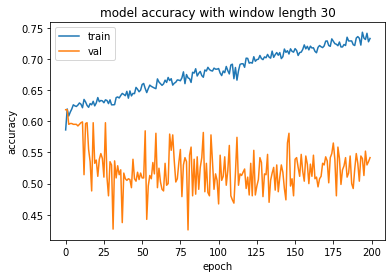

In [0]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 30')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

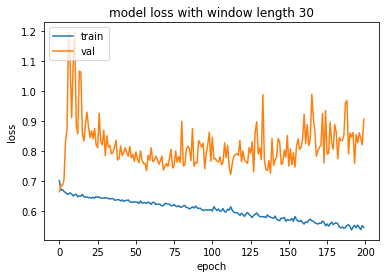

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 30')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 30 we have: test loss, test acc:', results)

160/160 [==============================] - 0s 254us/step
for window length 30 we have: test loss, test acc: [1.1740493297576904, 0.6499999761581421]


**Now, Let's train the model with window size of 10 again, but increase the number of epochs to 1000**

In [0]:
training_data, training_labels, validation_data, validation_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end)

model = build_model(training_data.shape, optimizer)
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_49 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)                64        
_________________________________________________________________
dense_51 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_52 (Dense)             (None, 1)               

In [0]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=1000,
                    shuffle=False,
                    validation_data=(validation_data, validation_labels))

Train on 3008 samples, validate on 768 samples
Epoch 1/1000
3008/3008 [==============================] - 3s 1ms/step - loss: 0.7031 - binary_accuracy: 0.5961 - val_loss: 0.6699 - val_binary_accuracy: 0.6185
Epoch 2/1000
3008/3008 [==============================] - 3s 854us/step - loss: 0.6733 - binary_accuracy: 0.6084 - val_loss: 0.6890 - val_binary_accuracy: 0.5964
Epoch 3/1000
3008/3008 [==============================] - 3s 852us/step - loss: 0.6676 - binary_accuracy: 0.6147 - val_loss: 0.6934 - val_binary_accuracy: 0.5951
Epoch 4/1000
3008/3008 [==============================] - 3s 850us/step - loss: 0.6556 - binary_accuracy: 0.6263 - val_loss: 0.8131 - val_binary_accuracy: 0.5964
Epoch 5/1000
3008/3008 [==============================] - 3s 857us/step - loss: 0.6614 - binary_accuracy: 0.6240 - val_loss: 0.8336 - val_binary_accuracy: 0.5964
Epoch 6/1000
3008/3008 [==============================] - 3s 846us/step - loss: 0.6580 - binary_accuracy: 0.6220 - val_loss: 1.2621 - val_binary_

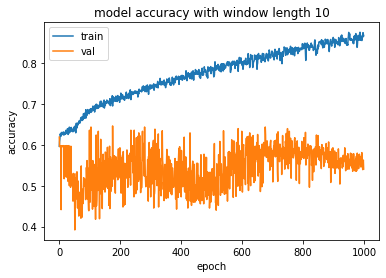

In [0]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

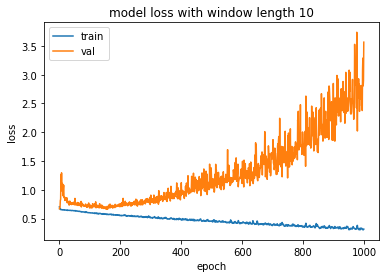

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 10 we have: test loss, test acc:', results)

160/160 [==============================] - 0s 142us/step
for window length 10 we have: test loss, test acc: [3.516043040913041, 0.581250011920929]


**Now, Let's train the model on the whole dataset with no test data, also with window length of 10**

In [0]:
_training_end = pandas.to_datetime('20200501', format='%Y%m%d', errors='ignore')

training_data, training_labels, _, _, _, _ = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, _training_end, None, None, validation_split=0.0, test_required=False)

model = build_model(training_data.shape, optimizer)
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_14 (Batc (None, 16)                64        
_________________________________________________________________
dense_55 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_56 (Dense)             (None, 1)               

In [0]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=1200,
                    shuffle=False
                    )

Epoch 1/1200
4384/4384 [==============================] - 4s 964us/step - loss: 0.6900 - binary_accuracy: 0.5837
Epoch 2/1200
4384/4384 [==============================] - 4s 815us/step - loss: 0.6787 - binary_accuracy: 0.5944
Epoch 3/1200
4384/4384 [==============================] - 4s 819us/step - loss: 0.6733 - binary_accuracy: 0.6024
Epoch 4/1200
4384/4384 [==============================] - 4s 822us/step - loss: 0.6710 - binary_accuracy: 0.5997
Epoch 5/1200
4384/4384 [==============================] - 4s 817us/step - loss: 0.6699 - binary_accuracy: 0.5990
Epoch 6/1200
4384/4384 [==============================] - 4s 818us/step - loss: 0.6677 - binary_accuracy: 0.6004
Epoch 7/1200
4384/4384 [==============================] - 4s 823us/step - loss: 0.6669 - binary_accuracy: 0.6022
Epoch 8/1200
4384/4384 [==============================] - 4s 821us/step - loss: 0.6660 - binary_accuracy: 0.6045
Epoch 9/1200
4384/4384 [==============================] - 4s 821us/step - loss: 0.6626 - binary_

Let's save the achieved model for further use.

In [0]:
model.save(join(COLAB_DIR,'model.h5'))

## **Stateful LSTM**

Until now, we have considered our model as a stateless model. However, that is not the case. One should realize that stateless models reset their state at the end of each batch and that is not desirable in sequence modeling. Thus, let's set the stateful flag in our model.

Now, let's generate the dataset and the model. All the parameters are initialized with their default value throughout this documentation. the window size is still 10.

In [54]:
training_start = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

training_data, training_labels, validation_data, validation_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, validation_split=0.2)


layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,training_data.shape[1], training_data.shape[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

model = build_model(training_data.shape, optimizer, layers)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (32, 64)                  17920     
_________________________________________________________________
dense_25 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_7 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_26 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_7 (Batch (32, 16)                  64        
_________________________________________________________________
dense_27 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_28 (Dense)             (32, 1)                  

In [0]:
epochs = 200


def fit(model, epochs, training_data, training_labels, validation_required, validation_data, validation_labels, batch_size=32):
  train_losses = []
  val_losses = []

  train_accs = []
  val_accs = []

  for i in range(epochs):
      print('Epoch', i + 1, '/', epochs)
      history = model.fit(training_data,
                        training_labels,
                        batch_size=32,
                        epochs=1,
                        shuffle=False,
                        verbose=0
                        )
      train_accs.append(history.history['binary_accuracy'])
      train_losses.append(history.history['loss'])
      model.reset_states()
      print( "train_loss: %.3f, train_binary_accuracy: %.3f" % (history.history['loss'][0], history.history['binary_accuracy'][0]) )
      if validation_required:
        val_loss, val_acc = model.evaluate(validation_data, validation_labels, batch_size=batch_size)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        model.reset_states()
        print('val_loss: %.3f, val_binary_accuracy: %.3f' % (val_loss, val_acc))
  return train_accs, val_accs, train_losses, val_losses

In [0]:
train_accs, val_accs, train_losses, val_losses = fit(model, epochs, training_data, training_labels, True, validation_data, validation_labels)

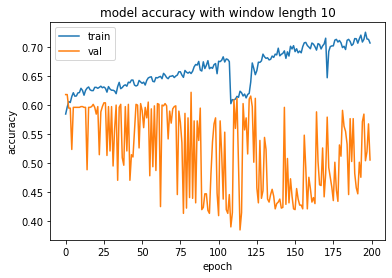

In [36]:
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

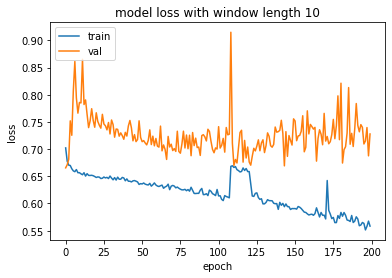

In [37]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 10 we have: test loss, test acc:', results)

160/160 [==============================] - 0s 127us/step
for window length 10 we have: test loss, test acc: [1.2594455105718225, 0.512499988079071]


Now, let's train the stateful model for 1000 epochs.

In [56]:
epochs = 1000
train_accs, val_accs, train_losses, val_losses = fit(model, epochs, training_data, training_labels, True, validation_data, validation_labels)

Epoch 1 / 1000
768/768 [==============================] - 0s 223us/step
val_loss: 0.687, train_loss: 0.740, train_binary_accuracy: 0.578,  val_binary_accuracy: 0.618
Epoch 2 / 1000
768/768 [==============================] - 0s 112us/step
val_loss: 0.677, train_loss: 0.685, train_binary_accuracy: 0.579,  val_binary_accuracy: 0.618
Epoch 3 / 1000
768/768 [==============================] - 0s 124us/step
val_loss: 0.683, train_loss: 0.675, train_binary_accuracy: 0.600,  val_binary_accuracy: 0.618
Epoch 4 / 1000
768/768 [==============================] - 0s 123us/step
val_loss: 0.726, train_loss: 0.674, train_binary_accuracy: 0.594,  val_binary_accuracy: 0.596
Epoch 5 / 1000
768/768 [==============================] - 0s 112us/step
val_loss: 0.735, train_loss: 0.674, train_binary_accuracy: 0.592,  val_binary_accuracy: 0.596
Epoch 6 / 1000
768/768 [==============================] - 0s 113us/step
val_loss: 0.741, train_loss: 0.669, train_binary_accuracy: 0.610,  val_binary_accuracy: 0.596
Epoc

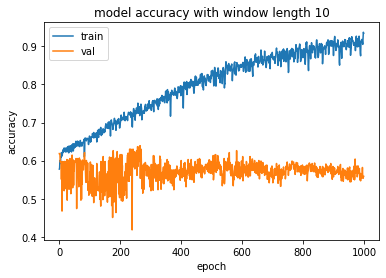

In [57]:
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

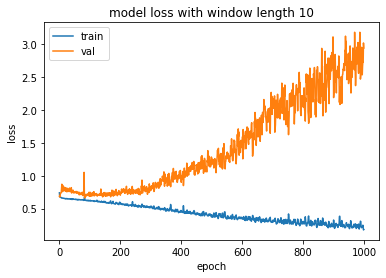

In [58]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 10 we have: test loss, test acc:', results)

160/160 [==============================] - 0s 144us/step
for window length 10 we have: test loss, test acc: [5.467251539230347, 0.40625]


Next, we train the model for 1200 epochs and save it for further use. This time, we have no validation and we train on the whole dataset.

In [76]:
_training_end = pandas.to_datetime('20200501', format='%Y%m%d', errors='ignore')

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,training_data.shape[1], training_data.shape[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]


training_data, training_labels, _, _, _, _ = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, _training_end, None, None, validation_split=0.0, test_required=False)

model = build_model(training_data.shape, optimizer, layers)
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (32, 64)                  17920     
_________________________________________________________________
dense_41 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_11 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_42 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_11 (Batc (32, 16)                  64        
_________________________________________________________________
dense_43 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_44 (Dense)             (32, 1)                 

In [77]:
epochs = 1200
fit(model, epochs, training_data, training_labels, False, None, None)

Epoch 1 / 1200
train_loss: 0.709, train_binary_accuracy: 0.574
Epoch 2 / 1200
train_loss: 0.680, train_binary_accuracy: 0.596
Epoch 3 / 1200
train_loss: 0.678, train_binary_accuracy: 0.599
Epoch 4 / 1200
train_loss: 0.676, train_binary_accuracy: 0.598
Epoch 5 / 1200
train_loss: 0.675, train_binary_accuracy: 0.597
Epoch 6 / 1200
train_loss: 0.673, train_binary_accuracy: 0.604
Epoch 7 / 1200
train_loss: 0.673, train_binary_accuracy: 0.604
Epoch 8 / 1200
train_loss: 0.672, train_binary_accuracy: 0.600
Epoch 9 / 1200
train_loss: 0.671, train_binary_accuracy: 0.607
Epoch 10 / 1200
train_loss: 0.669, train_binary_accuracy: 0.603
Epoch 11 / 1200
train_loss: 0.668, train_binary_accuracy: 0.604
Epoch 12 / 1200
train_loss: 0.669, train_binary_accuracy: 0.604
Epoch 13 / 1200
train_loss: 0.667, train_binary_accuracy: 0.603
Epoch 14 / 1200
train_loss: 0.667, train_binary_accuracy: 0.604
Epoch 15 / 1200
train_loss: 0.663, train_binary_accuracy: 0.607
Epoch 16 / 1200
train_loss: 0.666, train_binary_a

([[0.5739051],
  [0.5964872],
  [0.59945256],
  [0.59785587],
  [0.59694344],
  [0.60378647],
  [0.6035584],
  [0.59990877],
  [0.6069799],
  [0.6028741],
  [0.60378647],
  [0.6042427],
  [0.6031022],
  [0.6044708],
  [0.6074361],
  [0.60834855],
  [0.611542],
  [0.6033303],
  [0.59945256],
  [0.6076642],
  [0.60652375],
  [0.61222625],
  [0.61291057],
  [0.6163321],
  [0.61701643],
  [0.61906934],
  [0.62089413],
  [0.6163321],
  [0.620438],
  [0.611542],
  [0.6154197],
  [0.6133668],
  [0.62385947],
  [0.6206661],
  [0.62112224],
  [0.61929744],
  [0.62157845],
  [0.613823],
  [0.6186131],
  [0.62157845],
  [0.6222628],
  [0.62180656],
  [0.61291057],
  [0.618385],
  [0.62180656],
  [0.6181569],
  [0.62842155],
  [0.6224909],
  [0.6256843],
  [0.62363136],
  [0.6179288],
  [0.6259124],
  [0.61884123],
  [0.60880476],
  [0.6240876],
  [0.6179288],
  [0.6206661],
  [0.62112224],
  [0.6259124],
  [0.6256843],
  [0.62157845],
  [0.629562],
  [0.6343522],
  [0.6259124],
  [0.6368613],
  [

In [0]:
model.save(join(COLAB_DIR,'model_stateful.h5'))

## **Transfer Learning**

In this section, we load the pre-trained model and then do partial tuning with training it on the stock with second max trading days. Then, we test it to get accuracy of the model

In [0]:
stock_with_second_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[1]

In [0]:
train_start = pandas.to_datetime('20100101', format='%Y%m%d', errors='ignore')
train_end = pandas.to_datetime('20160719', format='%Y%m%d', errors='ignore')
test_start = pandas.to_datetime('20170101', format='%Y%m%d', errors='ignore')
test_end = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')

Next, we load the pretrained model

In [0]:
training_data, training_labels, validation_data, validation_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_second_max_trading_days, train_start, train_end, test_start, test_end)

In [63]:
from keras.models import load_model

base_model = build_model(training_data.shape, optimizer)
base_model.load_weights(join(COLAB_DIR,'model.h5'))
base_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_8 (Batch (None, 16)                64        
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                

In [64]:
history = base_model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=200,
                    shuffle=False,
                    validation_data=(validation_data, validation_labels))

Train on 1280 samples, validate on 320 samples
Epoch 1/200
1280/1280 [==============================] - 2s 1ms/step - loss: 1.2694 - binary_accuracy: 0.5250 - val_loss: 2.2815 - val_binary_accuracy: 0.4469
Epoch 2/200
1280/1280 [==============================] - 1s 842us/step - loss: 0.8852 - binary_accuracy: 0.5063 - val_loss: 0.9398 - val_binary_accuracy: 0.4594
Epoch 3/200
1280/1280 [==============================] - 1s 841us/step - loss: 0.8057 - binary_accuracy: 0.5242 - val_loss: 0.7519 - val_binary_accuracy: 0.4938
Epoch 4/200
1280/1280 [==============================] - 1s 836us/step - loss: 0.7376 - binary_accuracy: 0.5539 - val_loss: 0.7265 - val_binary_accuracy: 0.5500
Epoch 5/200
1280/1280 [==============================] - 1s 811us/step - loss: 0.6925 - binary_accuracy: 0.5758 - val_loss: 0.7242 - val_binary_accuracy: 0.5469
Epoch 6/200
1280/1280 [==============================] - 1s 842us/step - loss: 0.6664 - binary_accuracy: 0.6016 - val_loss: 0.7101 - val_binary_accura

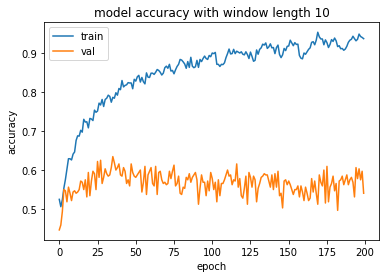

In [65]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

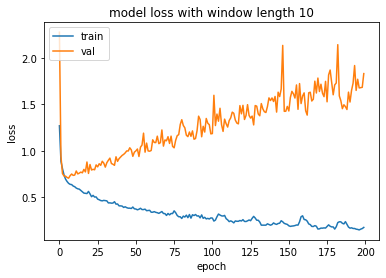

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
results = base_model.evaluate(testing_data, testing_labels)
print('for window length 10 we have: test loss, test acc:', results)

256/256 [==============================] - 0s 133us/step
for window length 10 we have: test loss, test acc: [1.6500323414802551, 0.48046875]


Now, Let's do this scenario again, but with stateful model.

In [89]:
layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,training_data.shape[1], training_data.shape[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]
base_model = build_model(training_data.shape, optimizer, layers)
base_model.load_weights(join(COLAB_DIR,'model_stateful.h5'))
base_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (32, 64)                  17920     
_________________________________________________________________
dense_57 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_15 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_58 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_15 (Batc (32, 16)                  64        
_________________________________________________________________
dense_59 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_60 (Dense)             (32, 1)                 

In [90]:
epochs = 200
train_accs, val_accs, train_losses, val_losses = fit(base_model, epochs, training_data, training_labels, True, validation_data, validation_labels)

Epoch 1 / 200
train_loss: 1.108, train_binary_accuracy: 0.508
320/320 [==============================] - 0s 379us/step
val_loss: 0.893, val_binary_accuracy: 0.431
Epoch 2 / 200
train_loss: 0.710, train_binary_accuracy: 0.516
320/320 [==============================] - 0s 117us/step
val_loss: 0.698, val_binary_accuracy: 0.488
Epoch 3 / 200
train_loss: 0.701, train_binary_accuracy: 0.543
320/320 [==============================] - 0s 110us/step
val_loss: 0.723, val_binary_accuracy: 0.488
Epoch 4 / 200
train_loss: 0.682, train_binary_accuracy: 0.562
320/320 [==============================] - 0s 118us/step
val_loss: 0.696, val_binary_accuracy: 0.544
Epoch 5 / 200
train_loss: 0.671, train_binary_accuracy: 0.595
320/320 [==============================] - 0s 118us/step
val_loss: 0.698, val_binary_accuracy: 0.509
Epoch 6 / 200
train_loss: 0.676, train_binary_accuracy: 0.574
320/320 [==============================] - 0s 112us/step
val_loss: 0.686, val_binary_accuracy: 0.550
Epoch 7 / 200
train_lo

In [91]:
!ls

drive  model_stateful.h5  sample_data


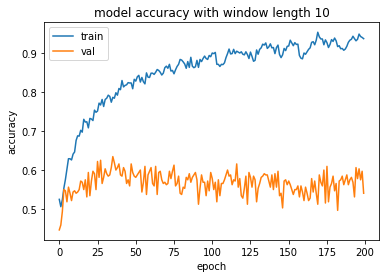

In [92]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

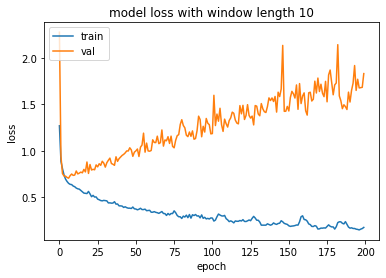

In [93]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [94]:
results = base_model.evaluate(testing_data, testing_labels)
print('for window length 10 we have: test loss, test acc:', results)

256/256 [==============================] - 0s 135us/step
for window length 10 we have: test loss, test acc: [1.1906770467758179, 0.44921875]
